In [66]:
"""
Spectral Normalization from https://arxiv.org/abs/1802.05957
"""
import torch
from torch.nn.functional import normalize
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import numpy as np

class SpectralNorm(object):
    # Invariant before and after each forward call:
    #   u = normalize(W @ v)
    # NB: At initialization, this invariant is not enforced

    _version = 2
    # At version 2:
    #   used Gouk 2018 method.
    #   will only normalize if largest singular value > magnitude    

    def __init__(self, name='weight', n_power_iterations=1, magnitude=1.0, eps=1e-12):
        self.name = name
        self.magnitude = magnitude
        if n_power_iterations <= 0:
            raise ValueError('Expected n_power_iterations to be positive, but '
                             'got n_power_iterations={}'.format(n_power_iterations))
        self.n_power_iterations = n_power_iterations
        self.eps = eps
    def l2norm(self, t):
        return torch.sqrt((t ** 2).sum())
    def compute_weight(self, module, do_power_iteration, num_iter=0):
        # NB: If `do_power_iteration` is set, the `u` and `v` vectors are
        #     updated in power iteration **in-place**. This is very important
        #     because in `DataParallel` forward, the vectors (being buffers) are
        #     broadcast from the parallelized module to each module replica,
        #     which is a new module object created on the fly. And each replica
        #     runs its own spectral norm power iteration. So simply assigning
        #     the updated vectors to the module this function runs on will cause
        #     the update to be lost forever. And the next time the parallelized
        #     module is replicated, the same randomly initialized vectors are
        #     broadcast and used!
        #
        #     Therefore, to make the change propagate back, we rely on two
        #     important bahaviors (also enforced via tests):
        #       1. `DataParallel` doesn't clone storage if the broadcast tensor
        #          is alreay on correct device; and it makes sure that the
        #          parallelized module is already on `device[0]`.
        #       2. If the out tensor in `out=` kwarg has correct shape, it will
        #          just fill in the values.
        #     Therefore, since the same power iteration is performed on all
        #     devices, simply updating the tensors in-place will make sure that
        #     the module replica on `device[0]` will update the _u vector on the
        #     parallized module (by shared storage).
        #
        #    However, after we update `u` and `v` in-place, we need to **clone**
        #    them before using them to normalize the weight. This is to support
        #    backproping through two forward passes, e.g., the common pattern in
        #    GAN training: loss = D(real) - D(fake). Otherwise, engine will
        #    complain that variables needed to do backward for the first forward
        #    (i.e., the `u` and `v` vectors) are changed in the second forward.
        weight = getattr(module, self.name + '_orig')
        u = getattr(module, self.name + '_u')
        
        if do_power_iteration:
            with torch.no_grad():
                for _ in range(max(self.n_power_iterations, num_iter)):
                    u = module.iteration_function(u, weight=weight)
                if self.n_power_iterations > 0:
                    # See above on why we need to clone
                    u = u.clone()
            sv = self.l2norm(module.forward_function(u, weight=weight)) / self.l2norm(u)      
            sigma = F.relu(sv / self.magnitude - 1.0) + 1.0
            module.sigma = sigma
            print ('Sigma', sigma.item(), 'SV', sv.item())
        else:
            sigma = module.sigma
        
        weight = weight / sigma
        return weight

    def remove(self, module):
        with torch.no_grad():
            weight = self.compute_weight(module, do_power_iteration=False)
        delattr(module, self.name)
        delattr(module, self.name + '_u')
        delattr(module, self.name + '_orig')
        module.register_parameter(self.name, torch.nn.Parameter(weight.detach()))

    def __call__(self, module, inputs, n_power_iterations=0):
        setattr(module, self.name, self.compute_weight(module, do_power_iteration=module.training, num_iter=n_power_iterations))

    @staticmethod
    def apply(module, name, n_power_iterations, magnitude, eps):
        for k, hook in module._forward_pre_hooks.items():
            if isinstance(hook, SpectralNorm) and hook.name == name:
                raise RuntimeError("Cannot register two spectral_norm hooks on "
                                   "the same parameter {}".format(name))

        fn = SpectralNorm(name, n_power_iterations, magnitude, eps)
        weight = module._parameters[name]
        
        functions_dict = {torch.nn.Conv1d : (F.conv1d, F.conv_transpose1d),
             torch.nn.Conv2d : (F.conv2d, F.conv_transpose2d),
             torch.nn.Conv3d : (F.conv3d, F.conv_transpose3d),
             torch.nn.ConvTranspose1d : (F.conv_transpose1d, F.conv1d),
             torch.nn.ConvTranspose2d : (F.conv_transpose2d, F.conv2d),
             torch.nn.ConvTranspose3d : (F.conv_transpose3d, F.conv3d),            
            }
        
        if isinstance(module, torch.nn.Linear):  
            module.forward_function = lambda inp,weight=weight: F.linear(inp, weight)
            module.iteration_function = lambda inp,weight=weight: F.linear(F.linear(inp, weight), weight.transpose(1,0))
        elif isinstance(module, (torch.nn.ConvTranspose1d,
                               torch.nn.ConvTranspose2d,
                               torch.nn.ConvTranspose3d,
                               torch.nn.Conv1d,
                               torch.nn.Conv2d,
                               torch.nn.Conv3d,)):
            k = weight.shape[2:]
            s = module.stride
            g = module.groups
            d = module.dilation
            p = module.padding
            functions = functions_dict[module.__class__ ]
            module.forward_function = lambda inp,weight=weight,s=s,g=g,d=d,p=p: functions[0](inp, weight, stride=s, padding=p, dilation=d, groups=g)            
            module.iteration_function = lambda inp,weight=weight,s=s,g=g,d=d,p=p: functions[1](functions[0](inp, weight, stride=s, padding=p, dilation=d, groups=g), 
                                                                                             weight, stride=s, padding=p, dilation=d, groups=g)
            
            
        with torch.no_grad():
            shape = (1,weight.shape[1])
            for i in range(0,len(weight.shape)-2):
                shape += (max(k[i]*d[i]-p[i],1),)
            u = torch.randn(shape).to(weight.device)
            

        delattr(module, fn.name)
        module.register_parameter(fn.name + "_orig", weight)
        # We still need to assign weight back as fn.name because all sorts of
        # things may assume that it exists, e.g., when initializing weights.
        # However, we can't directly assign as it could be an nn.Parameter and
        # gets added as a parameter. Instead, we register weight.data as a plain
        # attribute.
        setattr(module, fn.name, weight.data)
        module.register_buffer(fn.name + "_u", u)

        module.register_forward_pre_hook(fn)

        module._register_state_dict_hook(SpectralNormStateDictHook(fn))
        module._register_load_state_dict_pre_hook(SpectralNormLoadStateDictPreHook(fn))
        return fn


# This is a top level class because Py2 pickle doesn't like inner class nor an
# instancemethod.
class SpectralNormLoadStateDictPreHook(object):
    # See docstring of SpectralNorm._version on the changes to spectral_norm.
    def __init__(self, fn):
        self.fn = fn

    # For state_dict with version None, (assuming that it has gone through at
    # least one training forward), we have
    #
    #    u = normalize(W_orig @ v)
    #    W = W_orig / sigma, where sigma = u @ W_orig @ v
    #
    # To compute `v`, we solve `W_orig @ x = u`, and let
    #    v = x / (u @ W_orig @ x) * (W / W_orig).
    def __call__(self, state_dict, prefix, local_metadata, strict,
                 missing_keys, unexpected_keys, error_msgs):
        pass


# This is a top level class because Py2 pickle doesn't like inner class nor an
# instancemethod.
class SpectralNormStateDictHook(object):
    # See docstring of SpectralNorm._version on the changes to spectral_norm.
    def __init__(self, fn):
        self.fn = fn

    def __call__(self, module, state_dict, prefix, local_metadata):
        pass

def spectral_norm(module, name='weight', n_power_iterations=1, magnitude=1.0,eps=1e-12):
    r"""Applies spectral normalization to a parameter in the given module.

    .. math::
         \mathbf{W} = \dfrac{\mathbf{W}}{\sigma(\mathbf{W})} \\
         \sigma(\mathbf{W}) = \max_{\mathbf{h}: \mathbf{h} \ne 0} \dfrac{\|\mathbf{W} \mathbf{h}\|_2}{\|\mathbf{h}\|_2}

    Spectral normalization stabilizes the training of discriminators (critics)
    in Generaive Adversarial Networks (GANs) by rescaling the weight tensor
    with spectral norm :math:`\sigma` of the weight matrix calculated using
    power iteration method. If the dimension of the weight tensor is greater
    than 2, it is reshaped to 2D in power iteration method to get spectral
    norm. This is implemented via a hook that calculates spectral norm and
    rescales weight before every :meth:`~Module.forward` call.

    See `Spectral Normalization for Generative Adversarial Networks`_ .

    .. _`Spectral Normalization for Generative Adversarial Networks`: https://arxiv.org/abs/1802.05957

    Args:
        module (nn.Module): containing module
        name (str, optional): name of weight parameter
        n_power_iterations (int, optional): number of power iterations to
            calculate spectal norm
        eps (float, optional): epsilon for numerical stability in
            calculating norms
        dim (int, optional): dimension corresponding to number of outputs,
            the default is 0, except for modules that are instances of
            ConvTranspose1/2/3d, when it is 1

    Returns:
        The original module with the spectal norm hook

    Example::

        >>> m = spectral_norm(nn.Linear(20, 40))
        Linear (20 -> 40)
        >>> m.weight_u.size()
        torch.Size([20])

    """    
    SpectralNorm.apply(module, name, n_power_iterations, magnitude, eps)
    return module


def remove_spectral_norm(module, name='weight'):
    r"""Removes the spectral normalization reparameterization from a module.

    Args:
        module (nn.Module): containing module
        name (str, optional): name of weight parameter

    Example:
        >>> m = spectral_norm(nn.Linear(40, 10))
        >>> remove_spectral_norm(m)
    """
    for k, hook in module._forward_pre_hooks.items():
        if isinstance(hook, SpectralNorm) and hook.name == name:
            hook.remove(module)
            del module._forward_pre_hooks[k]
            return module

    raise ValueError("spectral_norm of '{}' not found in {}".format(
        name, module))

In [67]:
mod = spectral_norm(torch.nn.Linear(2,2), magnitude=0.5, n_power_iterations=5)
print (mod.weight, mod.weight.shape)
print (np.linalg.svd(mod.weight.squeeze().detach().numpy())[1] )
for k,hook in mod._forward_pre_hooks.items():
    if isinstance(hook,SpectralNorm):
        hook(mod, None)
print (mod.weight)
print (np.linalg.svd(mod.weight.squeeze().detach().numpy())[1] )

tensor([[ 0.2245, -0.3802],
        [ 0.6396, -0.3808]]) torch.Size([2, 2])
[0.8451742  0.18653041]
Sigma 1.6903483867645264 SV 0.8451741933822632
tensor([[ 0.1328, -0.2249],
        [ 0.3784, -0.2253]], grad_fn=<DivBackward0>)
[0.5        0.11035028]


In [68]:
z1 = 3
z2 = 4
k = 1
p = 0
s = 1
mod = spectral_norm(torch.nn.Conv2d(z1,z2,kernel_size=k, stride=1,padding=p, bias=False), magnitude=0.5, n_power_iterations=5)
print (mod.weight, mod.weight.shape)
print (np.linalg.svd(mod.weight.squeeze().detach().numpy())[1] )
for k,hook in mod._forward_pre_hooks.items():
    if isinstance(hook,SpectralNorm):
        hook(mod, None)
print (mod.weight)
print (np.linalg.svd(mod.weight.squeeze().detach().numpy())[1] )

tensor([[[[ 0.4480]],

         [[-0.4706]],

         [[ 0.3930]]],


        [[[-0.1183]],

         [[-0.1703]],

         [[ 0.1621]]],


        [[[ 0.3787]],

         [[-0.5623]],

         [[-0.1427]]],


        [[[-0.2847]],

         [[ 0.2867]],

         [[ 0.0048]]]]) torch.Size([4, 3, 1, 1])
[1.0353858  0.41194203 0.21789825]
Sigma 2.0707716941833496 SV 1.0353858470916748
tensor([[[[ 0.2163]],

         [[-0.2273]],

         [[ 0.1898]]],


        [[[-0.0571]],

         [[-0.0822]],

         [[ 0.0783]]],


        [[[ 0.1829]],

         [[-0.2715]],

         [[-0.0689]]],


        [[[-0.1375]],

         [[ 0.1384]],

         [[ 0.0023]]]], grad_fn=<DivBackward0>)
[0.5        0.19893166 0.10522563]


In [69]:
from torch.optim import *
import torch
import numpy as np
a = torch.nn.Linear(2,1, bias=False)
with torch.no_grad():
    a.weight *= 0.3
mod = spectral_norm(a, magnitude=0.5, n_power_iterations=1)
mod.cuda()
for k,hook in mod._forward_pre_hooks.items():
    if isinstance(hook,SpectralNorm):
        hook(mod, None)
list(mod.parameters())

Sigma 1.0 SV 0.1573978066444397


[Parameter containing:
 tensor([[-0.1564, -0.0174]], device='cuda:0', requires_grad=True)]

In [70]:
mod.state_dict()

OrderedDict([('weight_orig', tensor([[-0.1564, -0.0174]], device='cuda:0')),
             ('weight_u', tensor([[-0.1607,  0.9213]], device='cuda:0'))])

In [71]:
mod.weight

tensor([[-0.1564, -0.0174]], device='cuda:0', grad_fn=<DivBackward0>)

In [72]:
optim = Adam(mod.parameters(), lr=0.01)
b_items = []
mod.train()
for i in range(0,30):
    optim.zero_grad()
    b = (mod(torch.randn(512,2).cuda()) **2 ).sum() / 512
    b_items.append(b.item())    
    (-b).backward()
    optim.step()

Sigma 1.0 SV 0.1573978066444397
Sigma 1.0 SV 0.16867539286613464
Sigma 1.0 SV 0.1803453415632248
Sigma 1.0 SV 0.19234998524188995
Sigma 1.0 SV 0.20465518534183502
Sigma 1.0 SV 0.2172345519065857
Sigma 1.0 SV 0.2300589680671692
Sigma 1.0 SV 0.2430712878704071
Sigma 1.0 SV 0.2562938928604126
Sigma 1.0 SV 0.2697223126888275
Sigma 1.0 SV 0.2833470404148102
Sigma 1.0 SV 0.29715660214424133
Sigma 1.0 SV 0.31116312742233276
Sigma 1.0 SV 0.3253529369831085
Sigma 1.0 SV 0.33974698185920715
Sigma 1.0 SV 0.3542664349079132
Sigma 1.0 SV 0.3689681887626648
Sigma 1.0 SV 0.3838225305080414
Sigma 1.0 SV 0.39887383580207825
Sigma 1.0 SV 0.4140912890434265
Sigma 1.0 SV 0.42951691150665283
Sigma 1.0 SV 0.44505244493484497
Sigma 1.0 SV 0.4607747197151184
Sigma 1.0 SV 0.4766663908958435
Sigma 1.0 SV 0.4926689863204956
Sigma 1.0175714492797852 SV 0.5087857246398926
Sigma 1.046984076499939 SV 0.5234920382499695
Sigma 1.0737971067428589 SV 0.5368985533714294
Sigma 1.098128080368042 SV 0.549064040184021
Sigma 

In [73]:
list(mod.parameters())

[Parameter containing:
 tensor([[-0.4647, -0.3306]], device='cuda:0', requires_grad=True)]

In [74]:
mod.state_dict()

OrderedDict([('weight_orig', tensor([[-0.4647, -0.3306]], device='cuda:0')),
             ('weight_u', tensor([[-0.1607,  0.9213]], device='cuda:0'))])

In [75]:
mod.weight

tensor([[-0.4084, -0.2885]], device='cuda:0', grad_fn=<DivBackward0>)

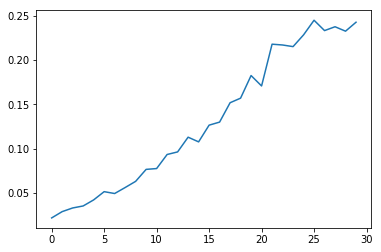

In [76]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(range(len(b_items)), b_items)

In [77]:
optim = Adam(mod.parameters(), lr=0.01)
b_items = []
mod.train()
for i in range(0,100):
    optim.zero_grad()
    b = (mod(torch.randn(512,2).cuda()) **2 ).sum() / 512
    b_items.append(b.item())    
    (b).backward()
    optim.step()

Sigma 1.1405935287475586 SV 0.5702967643737793
Sigma 1.1456331014633179 SV 0.5728165507316589
Sigma 1.1440041065216064 SV 0.5720020532608032
Sigma 1.1421042680740356 SV 0.5710521340370178
Sigma 1.1411066055297852 SV 0.5705533027648926
Sigma 1.1393457651138306 SV 0.5696728825569153
Sigma 1.1369109153747559 SV 0.5684554576873779
Sigma 1.1341867446899414 SV 0.5670933723449707
Sigma 1.1318773031234741 SV 0.5659386515617371
Sigma 1.1315183639526367 SV 0.5657591819763184
Sigma 1.1311603784561157 SV 0.5655801892280579
Sigma 1.1305227279663086 SV 0.5652613639831543
Sigma 1.130068063735962 SV 0.565034031867981
Sigma 1.1296894550323486 SV 0.5648447275161743
Sigma 1.1293842792510986 SV 0.5646921396255493
Sigma 1.1287726163864136 SV 0.5643863081932068
Sigma 1.1284666061401367 SV 0.5642333030700684
Sigma 1.1277714967727661 SV 0.5638857483863831
Sigma 1.1270238161087036 SV 0.5635119080543518
Sigma 1.1265194416046143 SV 0.5632597208023071
Sigma 1.1261667013168335 SV 0.5630833506584167
Sigma 1.1258878

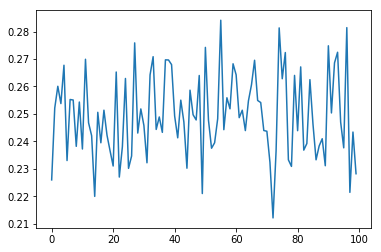

In [78]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(range(len(b_items)), b_items)

In [36]:
z1 = 3
z2 = 3
k = 3
p = 0
s = 1
mod = spectral_norm(torch.nn.Conv2d(z1,z2,kernel_size=k, stride=1,padding=p, bias=False), magnitude=1.0, n_power_iterations=5)
for k,hook in mod._forward_pre_hooks.items():
    if isinstance(hook,SpectralNorm):
        hook(mod, None)

Sigma 1.0 SV 0.7136117219924927


In [39]:
optim = Adam(mod.parameters(), lr=0.01)
b_items = []
mod.train()
for i in range(0,100):
    optim.zero_grad()
    b = (mod(torch.randn(512,3,3,3)) **2 ).sum() / 512
    b_items.append(b.item())    
    (-b).backward()
    optim.step()

Sigma 4.167289733886719 SV 4.167289733886719
Sigma 4.225738525390625 SV 4.225738525390625
Sigma 4.282241344451904 SV 4.282241344451904
Sigma 4.333850860595703 SV 4.333850860595703
Sigma 4.386666774749756 SV 4.386666774749756
Sigma 4.440177917480469 SV 4.440177917480469
Sigma 4.496182441711426 SV 4.496182441711426
Sigma 4.552465438842773 SV 4.552465438842773
Sigma 4.60589599609375 SV 4.60589599609375
Sigma 4.666216850280762 SV 4.666216850280762
Sigma 4.734256744384766 SV 4.734256744384766
Sigma 4.806213855743408 SV 4.806213855743408
Sigma 4.871756076812744 SV 4.871756076812744
Sigma 4.93955135345459 SV 4.93955135345459
Sigma 5.002038955688477 SV 5.002038955688477
Sigma 5.060133934020996 SV 5.060133934020996
Sigma 5.127727031707764 SV 5.127727031707764
Sigma 5.1913838386535645 SV 5.1913838386535645
Sigma 5.2508440017700195 SV 5.2508440017700195
Sigma 5.309813976287842 SV 5.309813976287842
Sigma 5.363395690917969 SV 5.363395690917969
Sigma 5.423892498016357 SV 5.423892498016357
Sigma 5.48

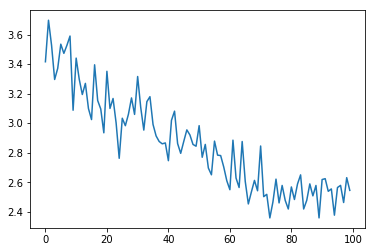

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(range(len(b_items)), b_items)

In [161]:
inva = torch.nn.ConvTranspose2d(z2,z1,kernel_size=k,stride=s,padding=p, bias=False)
print (a.weight.shape)
inva.weight = torch.nn.Parameter(a.weight.detach().clone())
print (inva.weight.shape)

torch.Size([4, 3, 1, 1])
torch.Size([4, 3, 1, 1])


In [155]:
def l2norm(t):
    return torch.sqrt((t ** 2).sum())

In [156]:
inp = torch.randn(1,z1,max(k*s-p,1),max(k*s-p,1))

In [157]:
for i in range(0,5):
    inp = inva(a(inp))

In [158]:
l2norm(a(inp)) / l2norm(inp)

tensor(1.0071, grad_fn=<DivBackward0>)

In [159]:
l2norm(a(inp)) / l2norm(inp)

tensor(1.0071, grad_fn=<DivBackward0>)

In [160]:
np.linalg.svd(a.weight.squeeze().detach().numpy())[1] 

array([1.008397  , 0.78237176, 0.37348843], dtype=float32)